# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

scanpy==1.3.2 anndata==0.6.11 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)

## Create input adata

In [ ]:
df = pd.read_csv("data/NeuronalGeneCount.csv", index_col=0)
/print df.shape

df = df.drop_duplicates(keep='first').T
/print df.shape
df.to_pickle('data/df.pkl')
df.head()

In [ ]:
df = pd.read_pickle('data/df.pkl')

In [ ]:
np.save('data/elegans/cells.npy', df.index.values)
np.save('data/elegans/genes.npy', df.columns)

In [ ]:
m = sparse.csr_matrix(df.as_matrix().T)

io.mmwrite("data/elegans/matrix.mtx", m)
del m, df

## Start from here if adata is available

In [3]:
%%time
path = './data/elegans/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = np.load('data/elegans/genes.npy')
adata.obs_names = np.load('data/elegans/cells.npy')

... reading from cache file ./cache/data-elegans-matrix.h5ad
Wall time: 180 ms


In [3]:
# adata = sc.read_10x_mtx(
#     './data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

... reading from cache file ./cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [4]:
adata.var_names_make_unique()

## Preprocessing

**Note:** In notebooks and jupyter lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

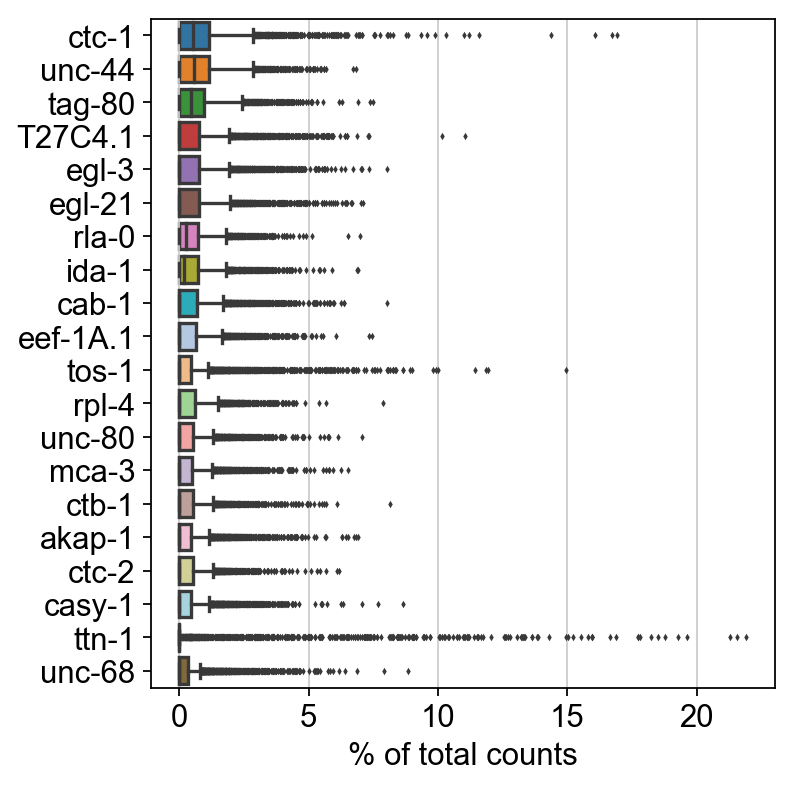

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 5581 cells that have less than 200 genes expressed
filtered out 2369 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):
> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [7]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

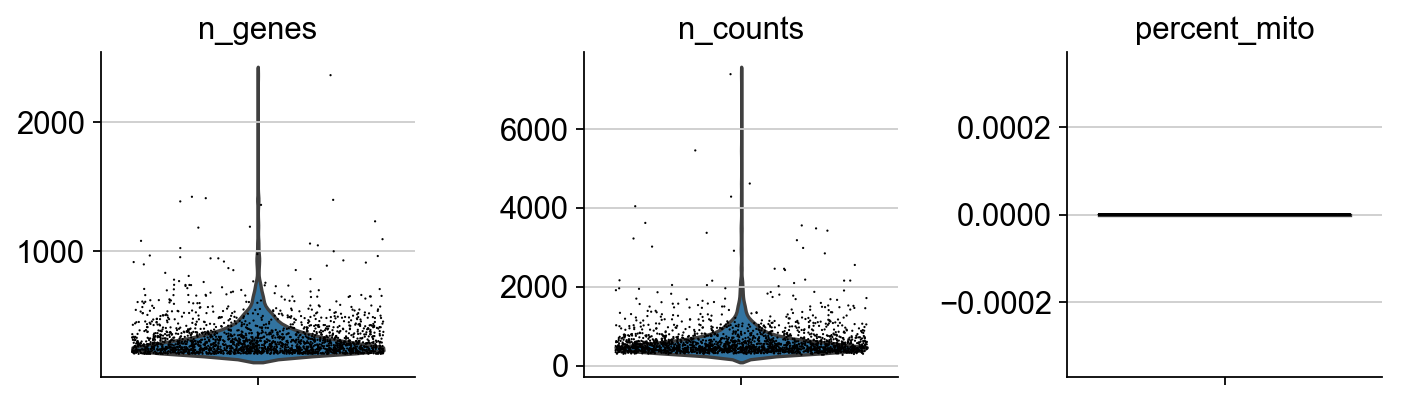

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

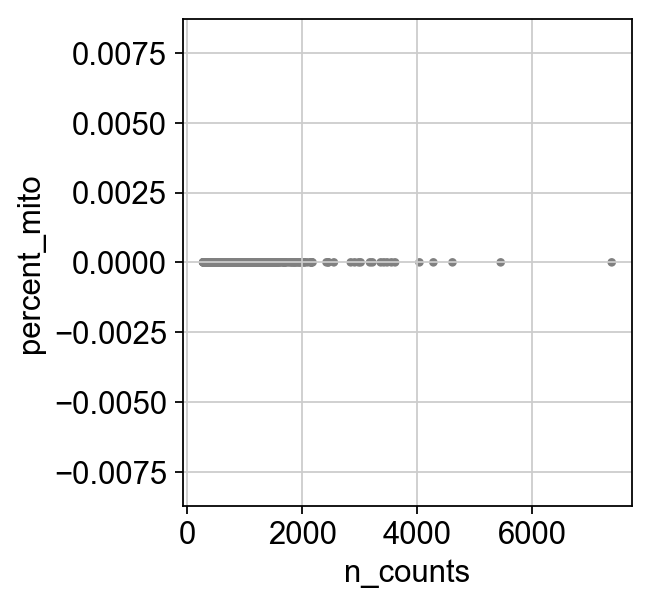

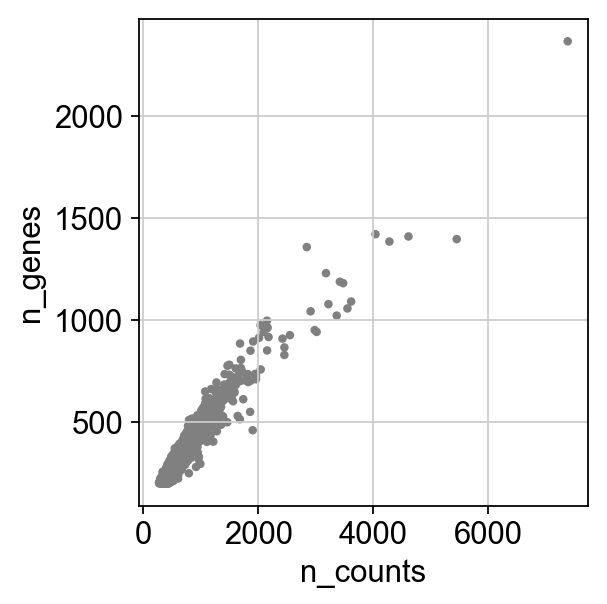

In [9]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [10]:
adata

AnnData object with n_obs × n_vars = 2022 × 9986 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

Actually do the filtering.

In [11]:
adata = adata[adata.obs['n_genes'] < 1250, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [12]:
adata.raw = sc.pp.log1p(adata, copy=True)

Per-cell normalize the data matrix $\mathbf{X}$. Many people would consider the normalized data matrix as the "relevant data" for visualization and differential testing (assessing feature importance). Until a common viewpoint is reached on this, the decision of what to consider "raw", is up to the user. We tend to recommend to use the normalized data for visualization and differential testing even though here, we use the non-normalized data for the sake of consistency with the Seurat tutorial.

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly-variable genes.

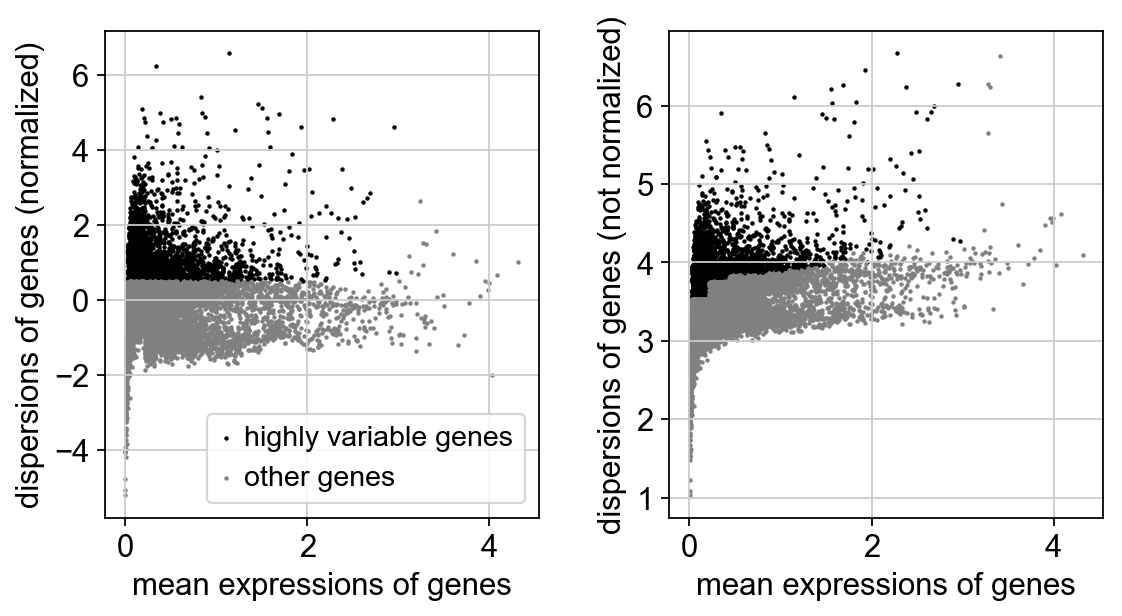

In [14]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [15]:
adata = adata[:, filter_result.gene_subset]

Logarithmize the data.

In [16]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [17]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:10.01)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [18]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [19]:
adata.write(results_file)

## PCA

Compute PCA and make a scatter plot.

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

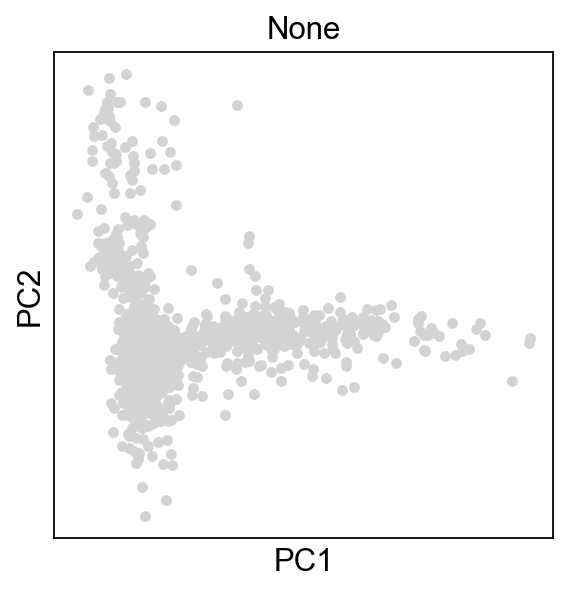

In [22]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

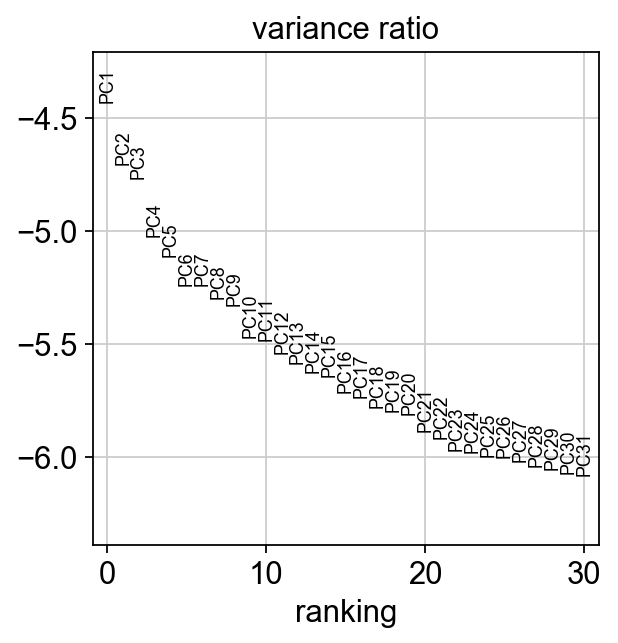

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file)

In [25]:
adata

AnnData object with n_obs × n_vars = 2016 × 2706 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [26]:
adata = sc.read(results_file)

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.82) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a notable speedup. Also, it is potentially more faithful to global topology: trajectories are better preserved.

In [28]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:04.20) --> added
    'X_umap', UMAP coordinates (adata.obsm)


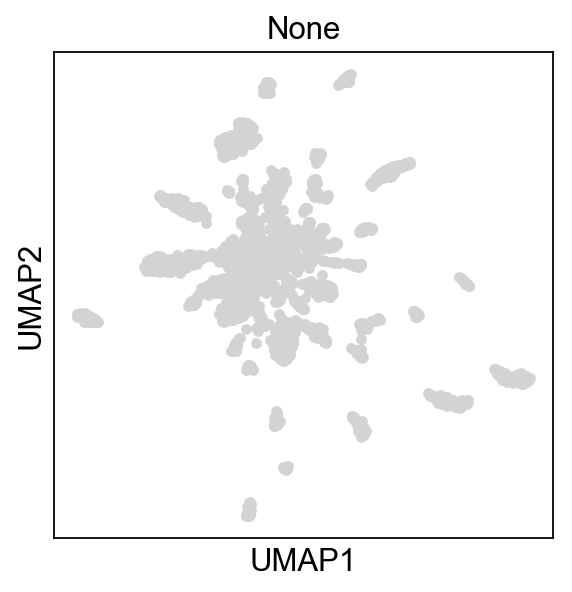

In [29]:
sc.pl.umap(adata)

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

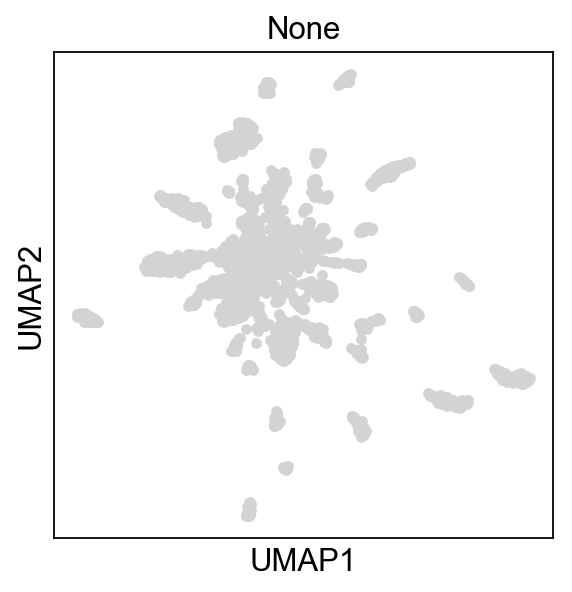

In [30]:
sc.pl.umap(adata, use_raw=False)

## Clustering the graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [31]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.15) --> found 34 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

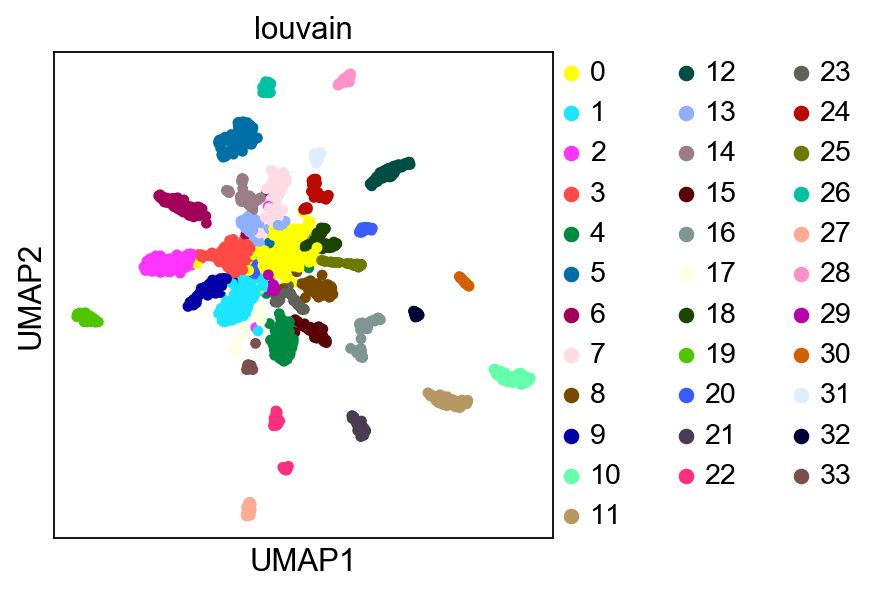

In [34]:
sc.pl.umap(adata, color=['louvain'])

In [33]:
adata.write(results_file)

In [35]:
adata.obs['louvain'].value_counts()

0     248
1     165
2     115
3     108
4     100
5      95
6      89
7      76
8      75
9      72
10     68
11     64
12     63
13     59
15     47
14     47
16     47
17     42
18     41
19     36
20     35
21     35
22     34
24     33
23     33
25     26
26     25
27     24
28     23
29     21
30     20
31     19
32     16
33     15
Name: louvain, dtype: int64

In [37]:
adata.obs['louvain'].to_csv("seurat.csv", header = False)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

ranking genes
    finished (0:00:01.18) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


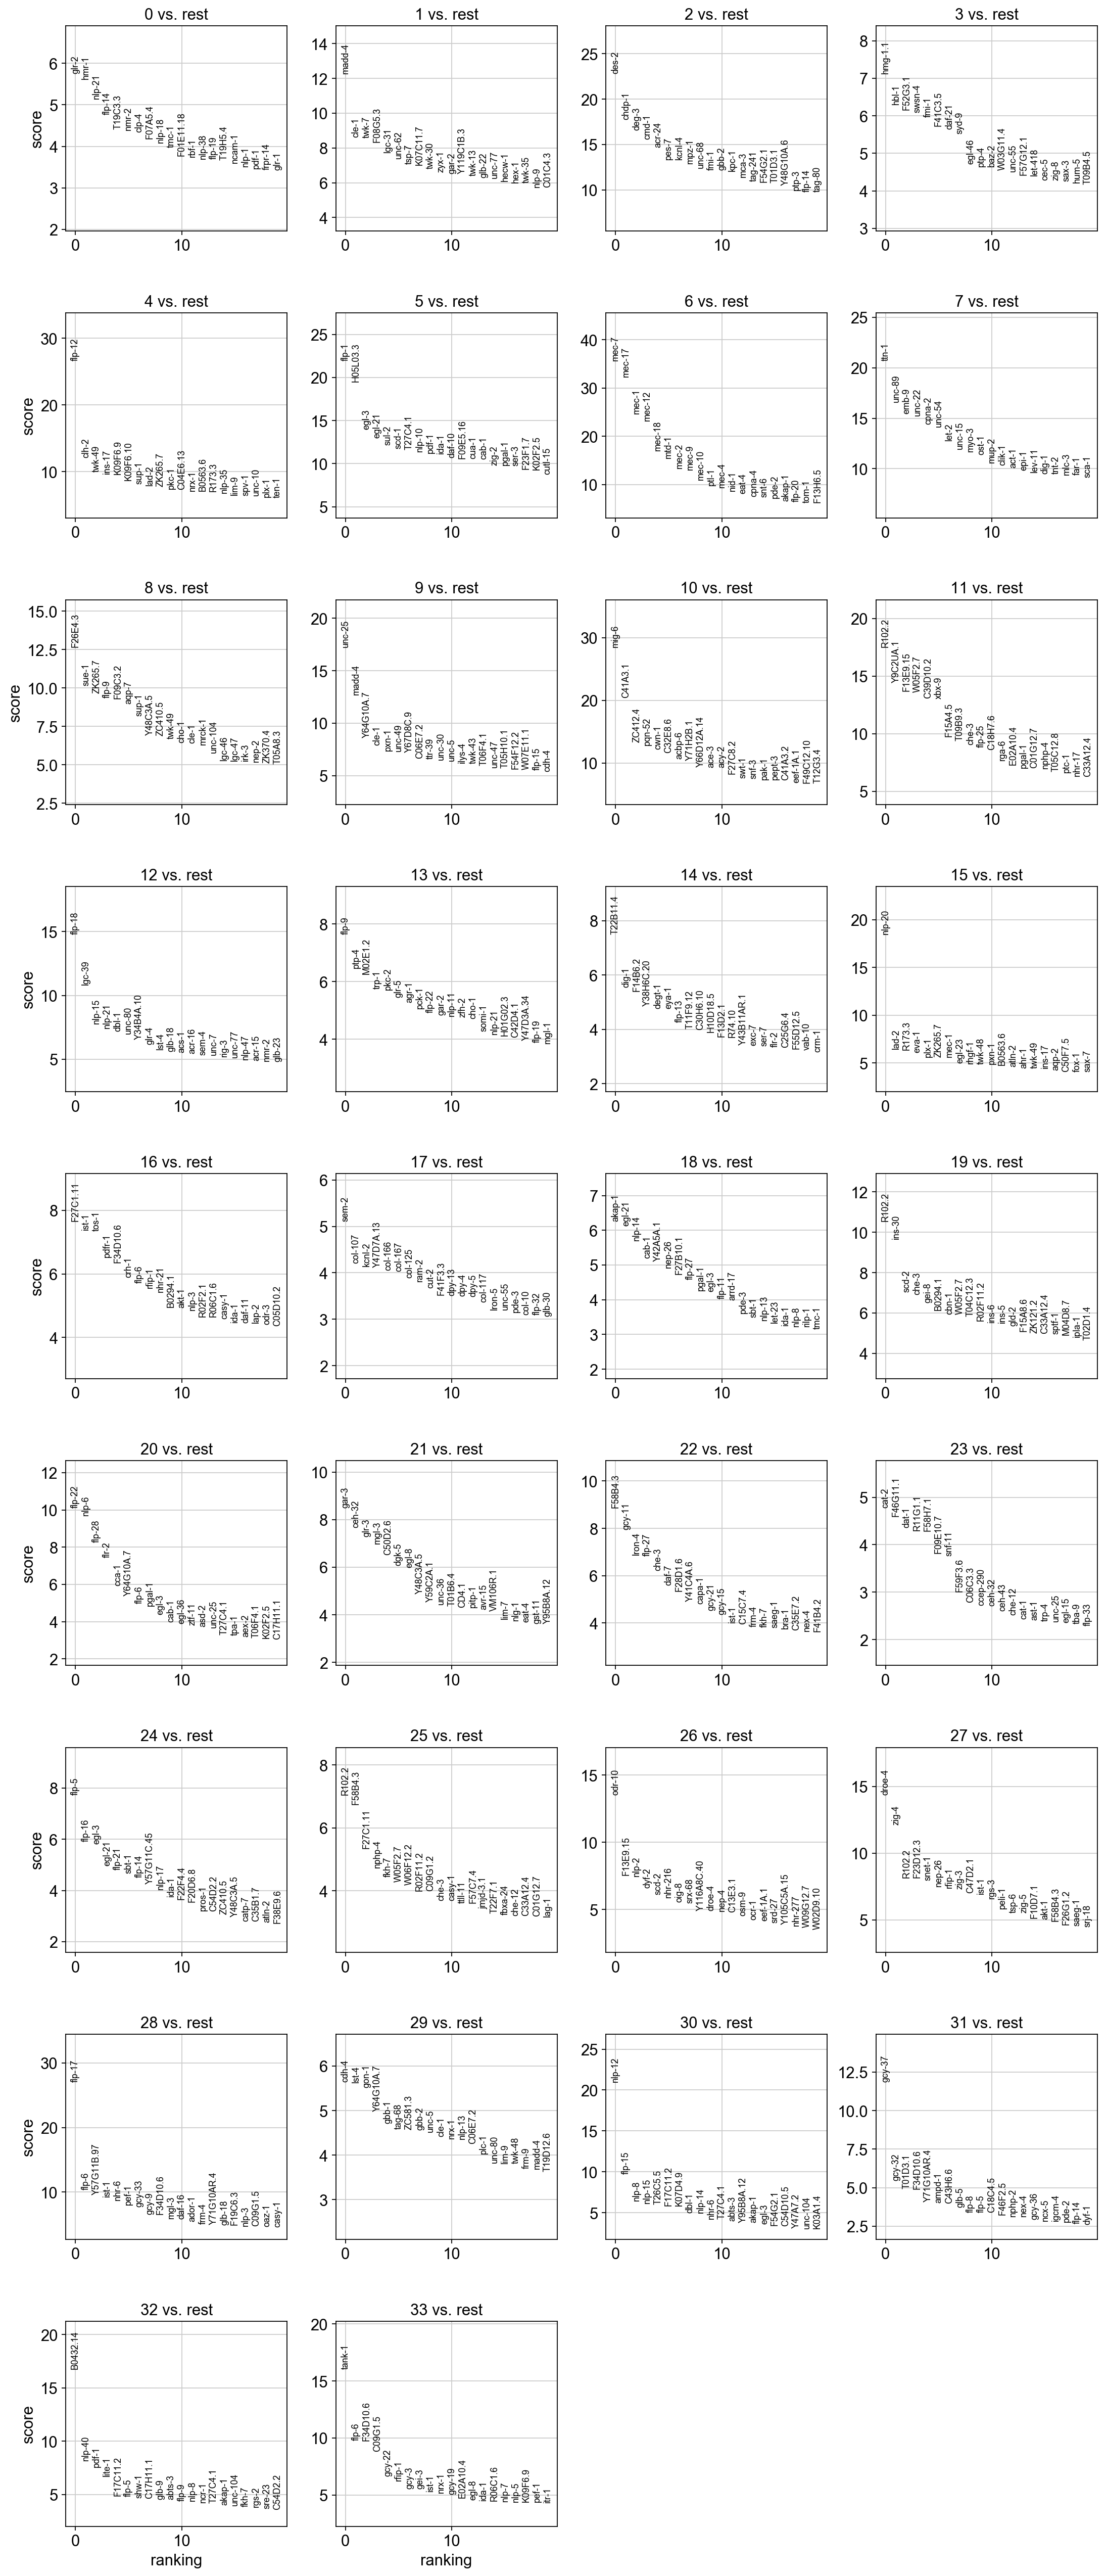

In [38]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save='.pdf')
adata.write(results_file)

In [39]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a Wilcoxon-Rank-Sum test is very similar.

ranking genes
    finished (0:00:02.09)


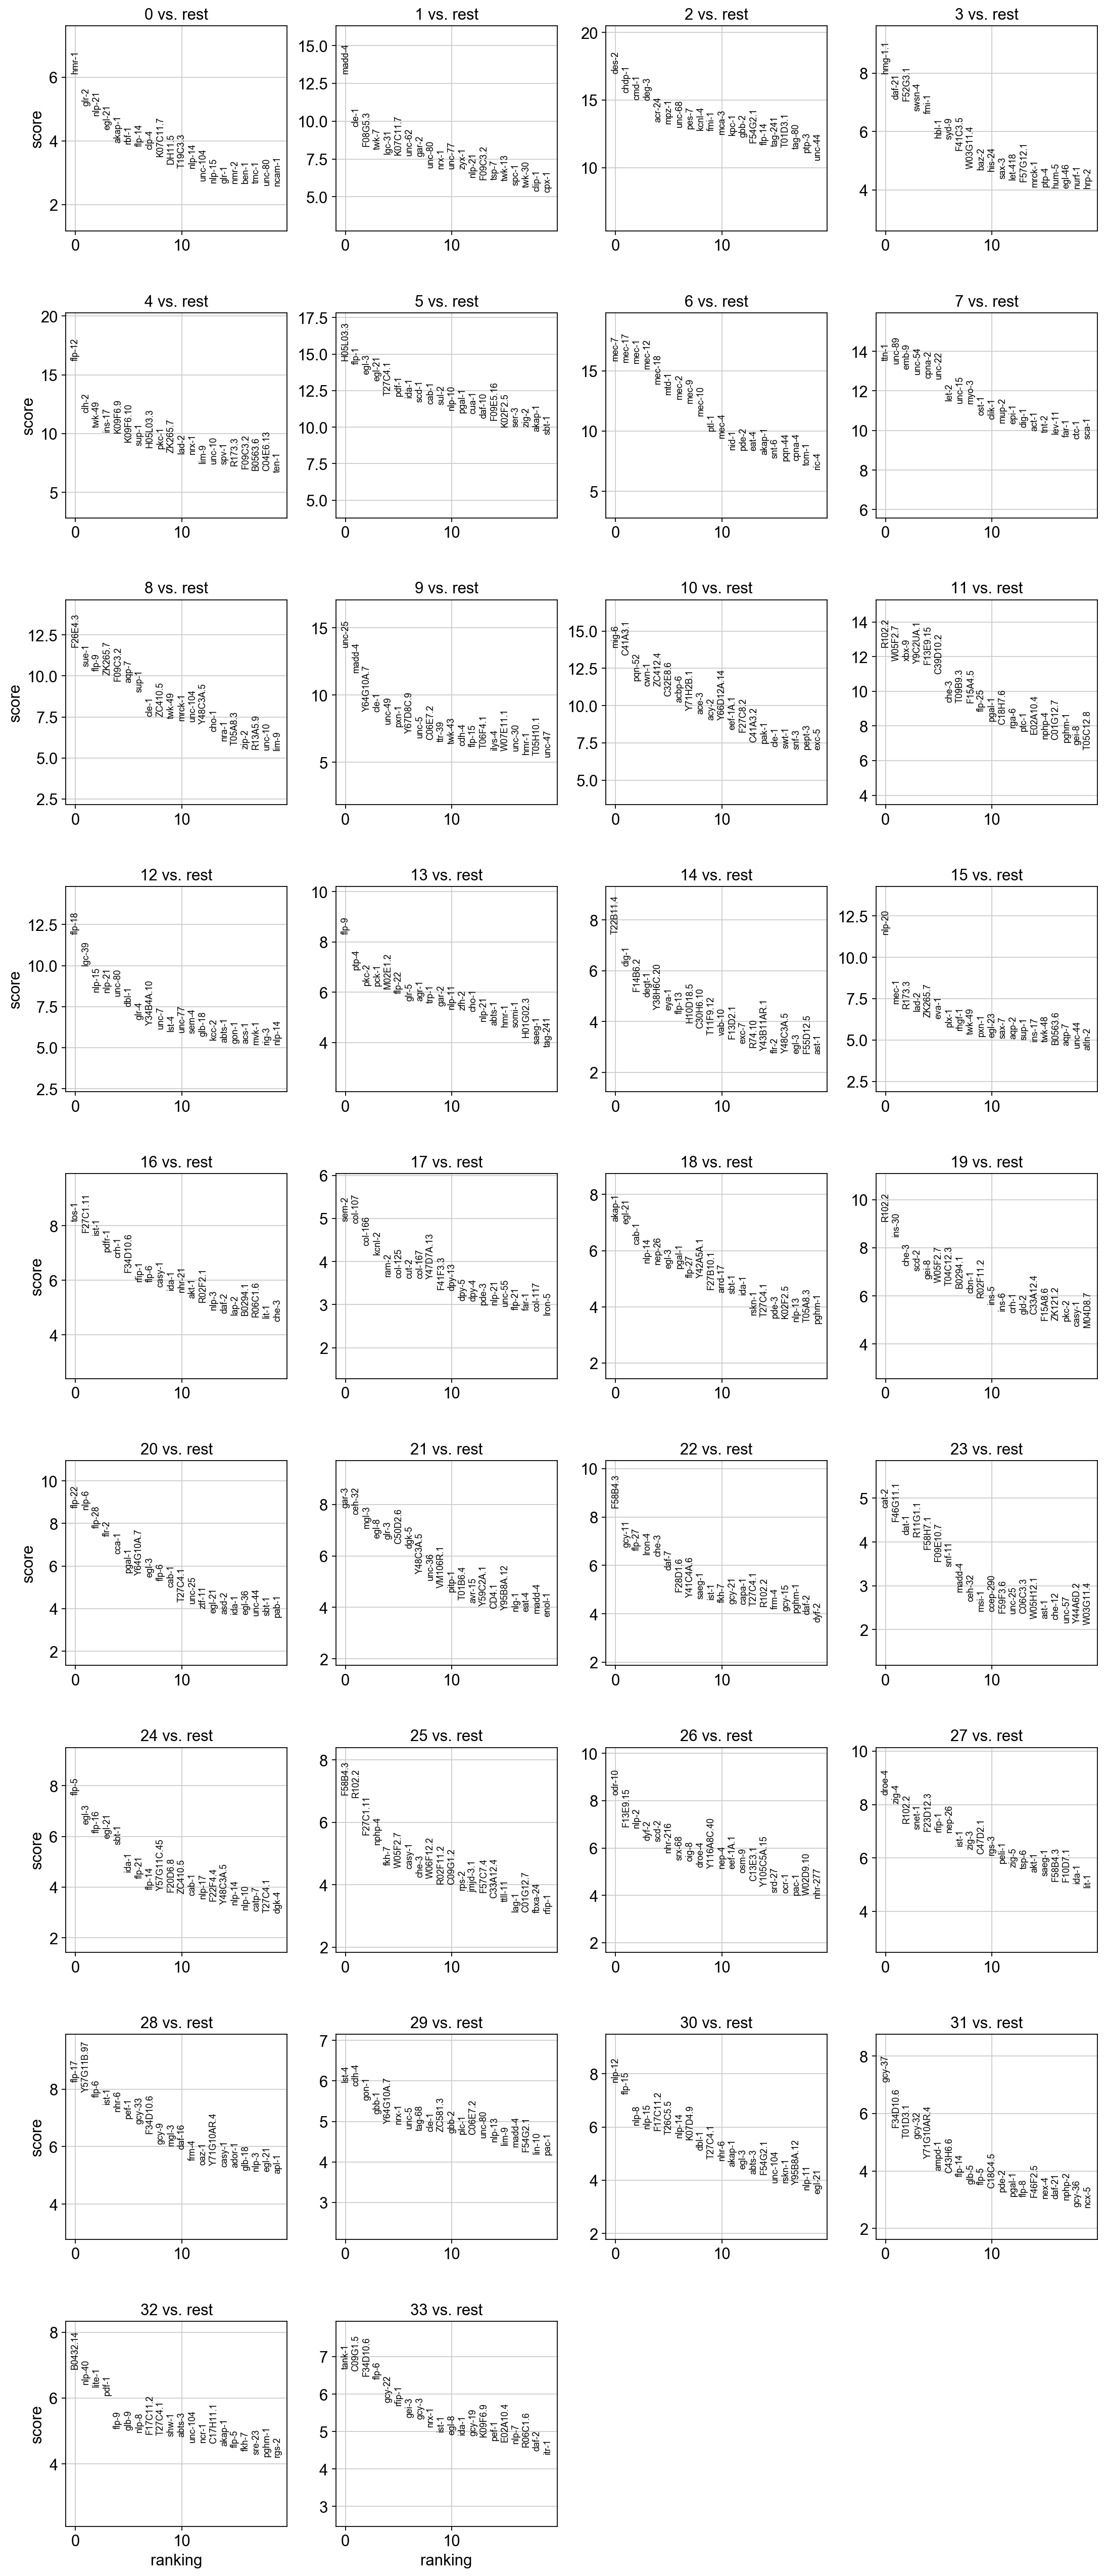

In [40]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos *et al.* (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate ([Clark *et al.*, 2014](https://doi.org/10.1186/1471-2105-15-79)).

ranking genes


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:03.48)


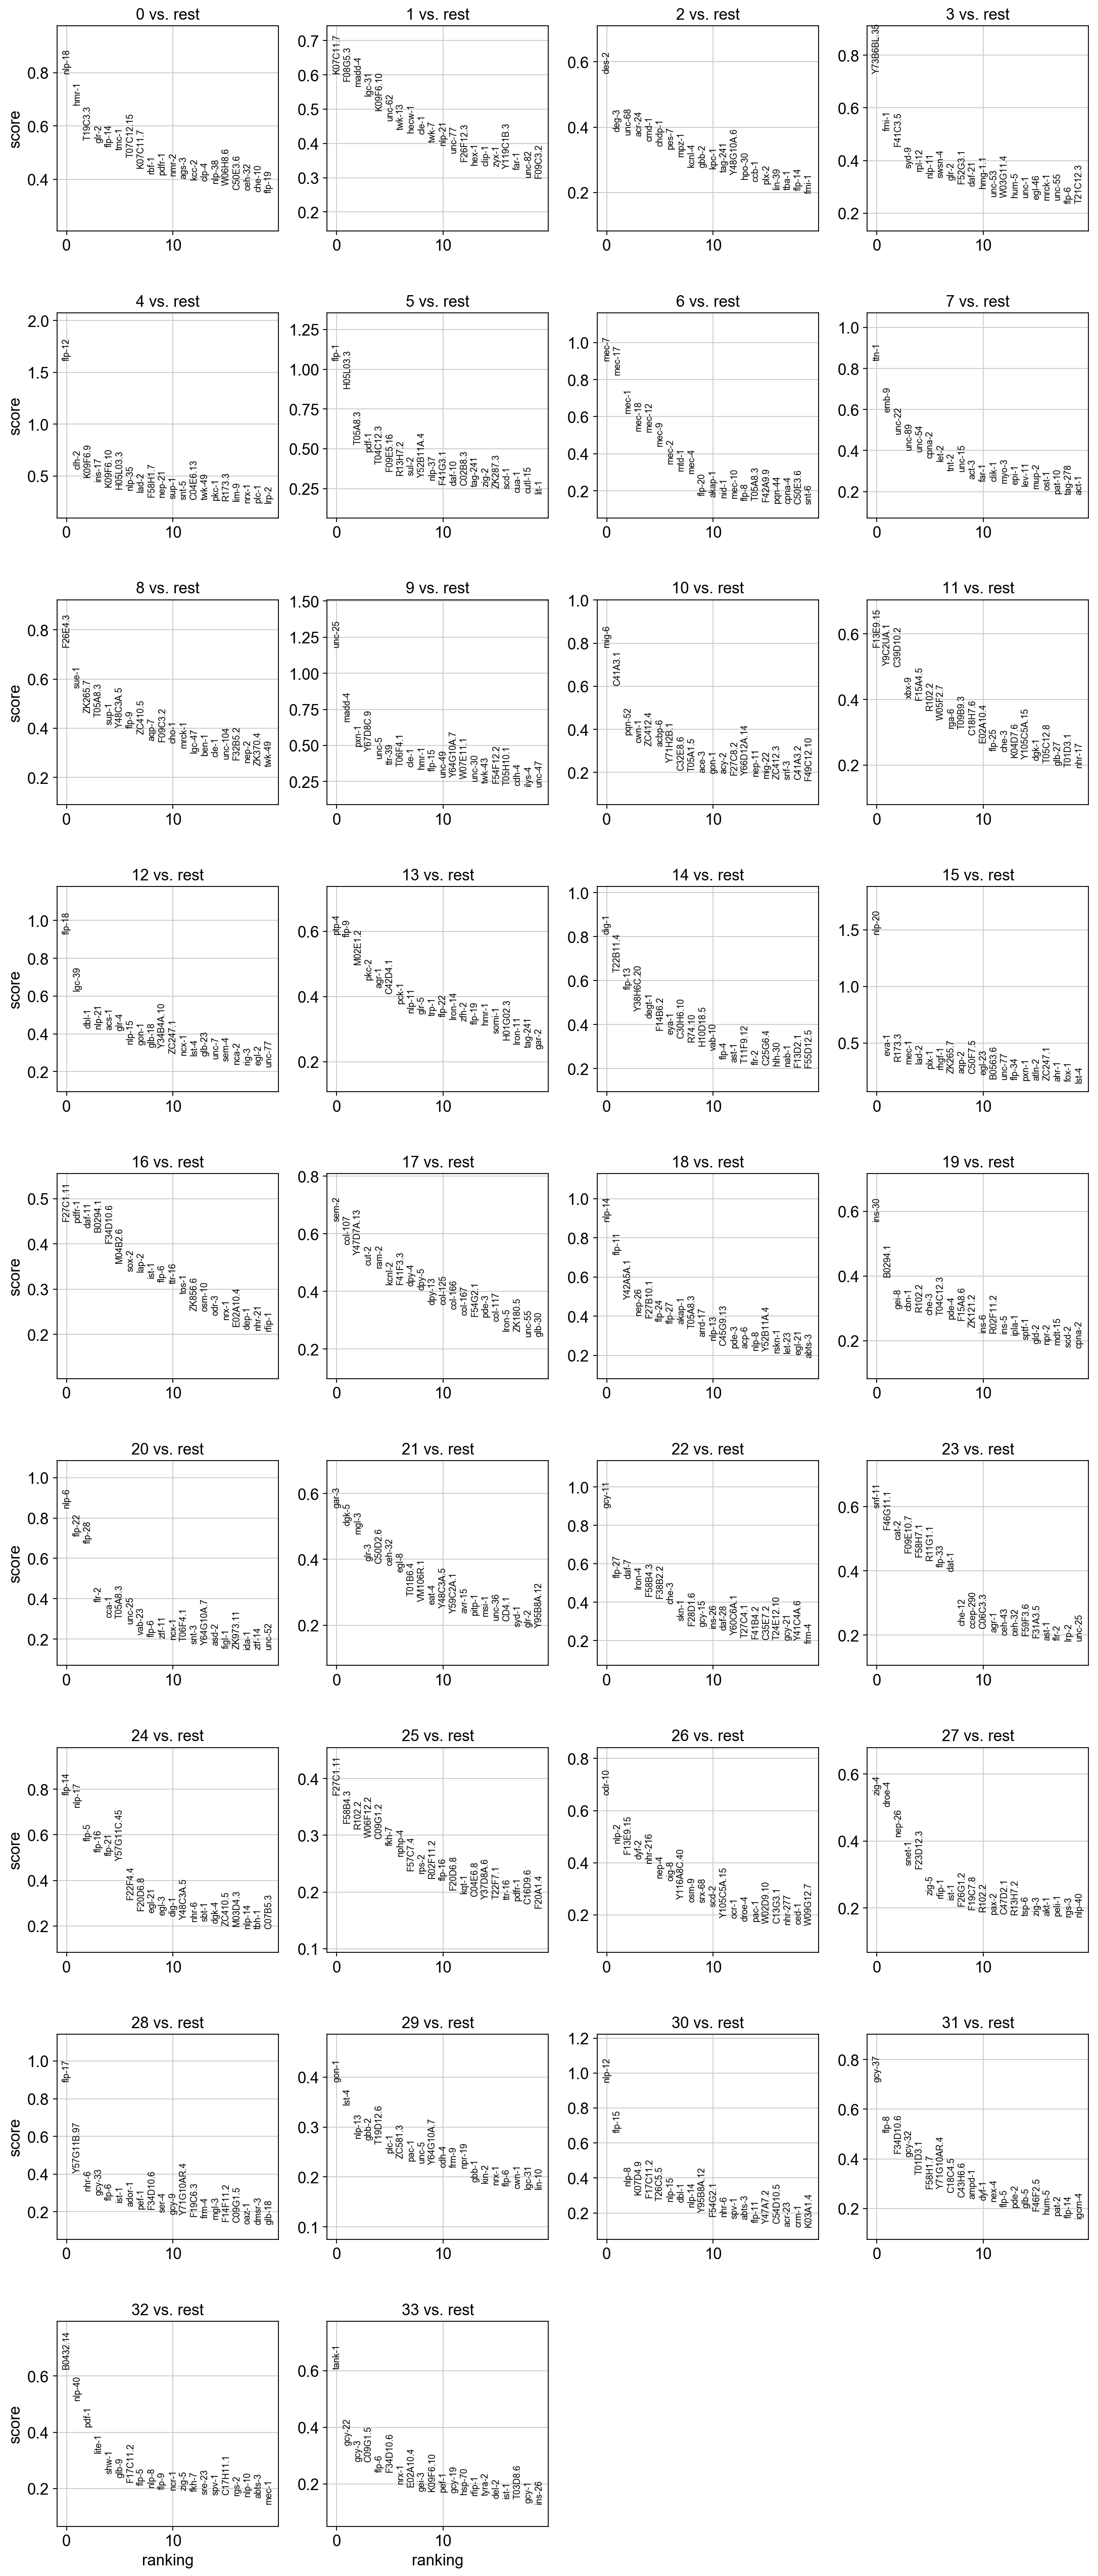

In [41]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

With the exception of IL7R, which is found only by the t-test at rank 17 but not by logistic regression, all marker genes are recovered using both approaches for ranking marker genes.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	GNLY, NKG7 | 	NK cells
5 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference. Here, we added a few more genes.

In [44]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [45]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1       2           3         4         5       6       7  \
0   nlp-18  K07C11.7   des-2  Y73B6BL.35    flp-12     flp-1   mec-7   ttn-1   
1    hmr-1   F08G5.3   deg-3       fmi-1     clh-2  H05L03.3  mec-17   emb-9   
2  T19C3.3    madd-4  unc-68     F41C3.5   K09F6.9   T05A8.3   mec-1  unc-22   
3    glr-2    lgc-31  acr-24       syd-9    ins-17     pdf-1  mec-18  unc-89   
4   flp-14  K09F6.10   cmd-1      rpl-12  K09F6.10  T04C12.3  mec-12  unc-54   

         8         9   ...         24        25        26        27  \
0  F26E4.3    unc-25   ...     flp-14  F27C1.11    odr-10     zig-4   
1    sue-1    madd-4   ...     nlp-17   F58B4.3     nlp-2    droe-4   
2  ZK265.7     pxn-1   ...      flp-5    R102.2  F13E9.15    nep-26   
3  T05A8.3  Y67D8C.9   ...     flp-16  W06F12.2     dyf-2    snet-1   
4    sup-1     unc-5   ...     flp-21   C09G1.2   nhr-216  F23D12.3   

           28        29        30        31        32       33  
0      flp-17     gon-1    nlp-12    gcy-37  B0432.14   tank-1  
1  Y57G11B.97     lst-4    flp-15     flp-8    nlp-40   gcy-22  
2       nhr-6    nlp-13     nlp-8  F34D10.6     pdf-1    gcy-3  
3      gcy-33     gbb-2   K07D4.9    gcy-32    lite-1  C09G1.5  
4       flp-6  T19D12.6  F17C11.2   T01D3.1     shw-1    flp-6  

[5 rows x 34 columns]

Get a table with the scores and groups.

In [46]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

0_n       0_s       1_n       1_s     2_n       2_s         3_n  \
0   nlp-18  0.798204  K07C11.7  0.604563   des-2  0.564621  Y73B6BL.35   
1    hmr-1  0.679587   F08G5.3  0.582990   deg-3  0.386549       fmi-1   
2  T19C3.3  0.548037    madd-4  0.567339  unc-68  0.377615     F41C3.5   
3    glr-2  0.537198    lgc-31  0.539245  acr-24  0.373480       syd-9   
4   flp-14  0.522792  K09F6.10  0.496827   cmd-1  0.357919      rpl-12   

        3_s       4_n       4_s    ...         29_n      29_s      30_n  \
0  0.731476    flp-12  1.617724    ...        gon-1  0.390869    nlp-12   
1  0.515066     clh-2  0.568872    ...        lst-4  0.345356    flp-15   
2  0.455472   K09F6.9  0.491358    ...       nlp-13  0.278398     nlp-8   
3  0.373143    ins-17  0.451959    ...        gbb-2  0.274847   K07D4.9   
4  0.360986  K09F6.10  0.397029    ...     T19D12.6  0.266255  F17C11.2   

       30_s      31_n      31_s      32_n      32_s     33_n      33_s  
0  0.950437    gcy-37  0.711058  B0432.14  0.626674   tank-1  0.607499  
1  0.660807     flp-8  0.506778    nlp-40  0.514524   gcy-22  0.336577  
2  0.358527  F34D10.6  0.424270     pdf-1  0.421591    gcy-3  0.280158  
3  0.306002    gcy-32  0.409057    lite-1  0.327496  C09G1.5  0.278464  
4  0.288328   T01D3.1  0.338125     shw-1  0.254075    flp-6  0.243620  

[5 rows x 68 columns]

Compare to a single cluster. 

ranking genes
    finished (0:00:00.01)


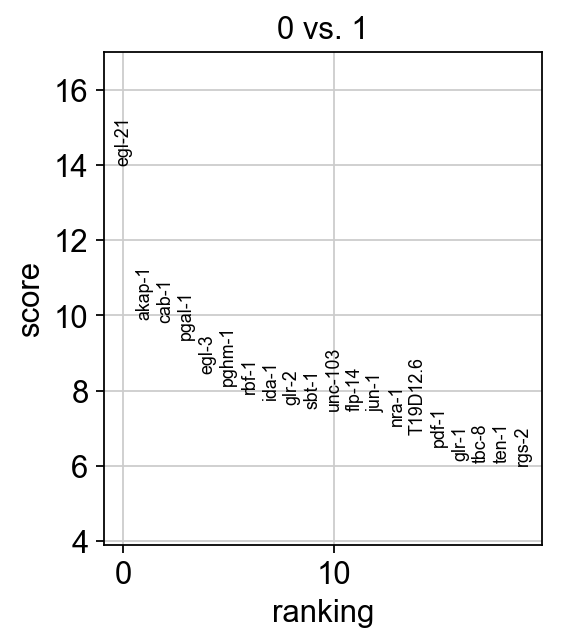

In [47]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes
    finished (0:00:00.35)


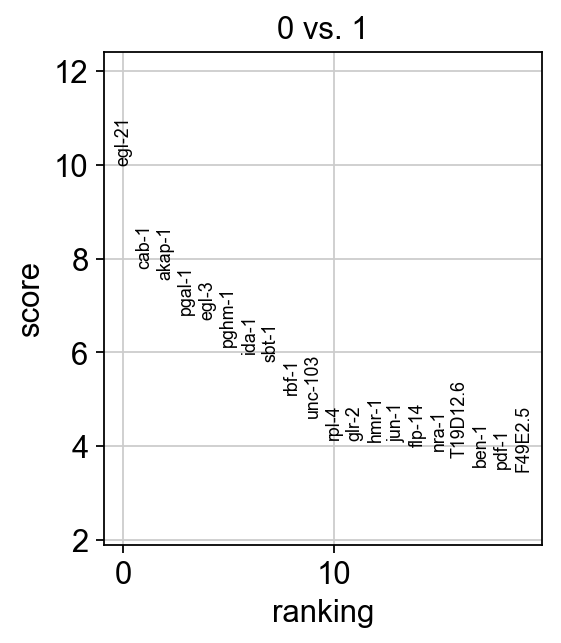

In [48]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

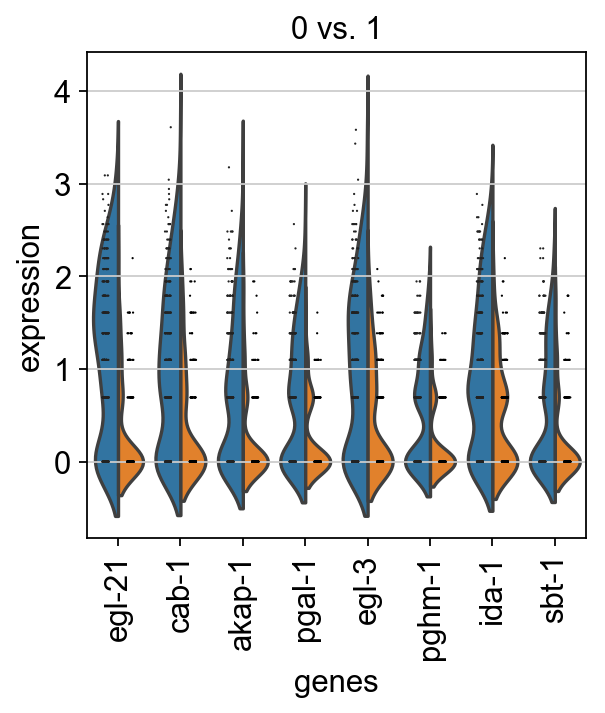

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reread the examples that were computed by comparing to the rest of the groups.

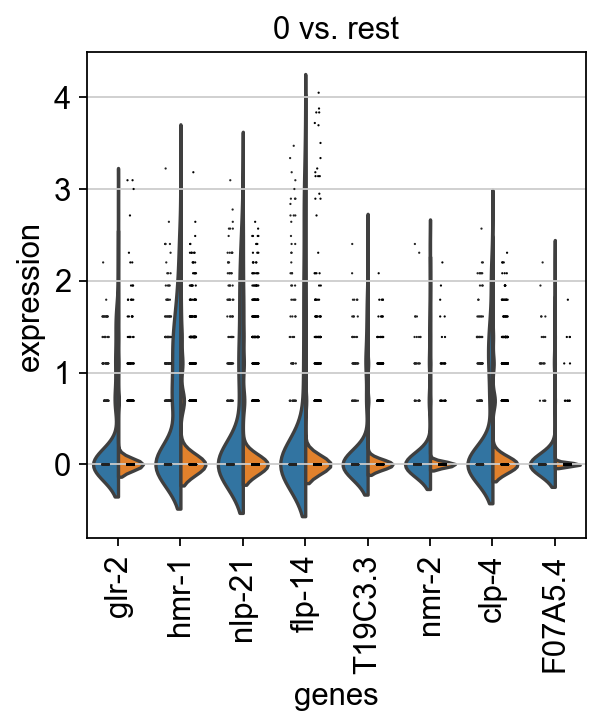

In [50]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.